# House Prices - Data Preprocessing & Linear Models

Based on earlier EDA, we know:

* There are a lot of missing values in the data
* There are also duplicative (highly-correlated) features that add no extra value
* `Id` can probably be safely deleted as it is simply a auto-incrementing label for each observation
* The target variable, `SalePrice`, is right skewed and will need to be log-transformed

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso, LassoCV

SEED = 42

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]

**Load the Data**

In [221]:
train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")
submission = pd.read_csv("assets/sample_submission.csv")

# Prepare our base training data
X = train_.copy()

# Drop the unnecessary Id column
X = X.drop(columns="Id")
test = test_.copy().drop(columns="Id")

In [222]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Create Helper Functions**

In [223]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

**Deal with Missing Values**

In [224]:
all_data = pd.concat([X.drop(columns="SalePrice"), test])
nulls = all_data.isnull().sum()[all_data.isnull().sum() > 0].sort_values(ascending=False).to_frame().rename(columns={0: "MissingVals"})
nulls["MissingValsPct"] = nulls["MissingVals"] / len(all_data)
nulls

,MissingVals,MissingValsPct
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


In [225]:
all_data[all_data["GarageYrBlt"].isnull()].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
39,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseP,1152,0,0,1152,0.0,0.0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand
48,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,736.0,736.0,GasA,Gd,Y,SBrkr,736,716,0,1452,0.0,0.0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial
78,90,RL,72.0,10778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1768.0,1768.0,GasA,TA,N,SBrkr,1768,0,0,1768,0.0,0.0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
88,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,1013.0,1013.0,GasA,TA,N,SBrkr,1013,0,513,1526,0.0,0.0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml
89,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588.0,Unf,0.0,402.0,990.0,GasA,Ex,Y,SBrkr,990,0,0,990,1.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal


In [226]:
# Very helpful: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

for df in [X, test, all_data]:
    ## EASIER TO HANDLE:
    
    # PoolQC -> data description says NA = No Pool
    df["PoolQC"].fillna(value="None", inplace=True)
    # MiscFeature -> data description says NA = None
    df["MiscFeature"].fillna(value="None", inplace=True)
    # Alley -> data description says NA = No alley access
    df["Alley"].fillna(value="None", inplace=True)
    # Fence -> data description says NA = No fence
    df["Fence"].fillna(value="None", inplace=True)
    # FireplaceQu -> data description says NA = No fireplace
    df["FireplaceQu"].fillna(value="None", inplace=True)
    # Garage features -> data description says NA = No garage
    df["GarageType"].fillna(value="None", inplace=True)
    df["GarageFinish"].fillna(value="None", inplace=True)
    df["GarageQual"].fillna(value="None", inplace=True)
    df["GarageCond"].fillna(value="None", inplace=True)
    df["GarageArea"].fillna(value=0, inplace=True)
    df["GarageCars"].fillna(value=0, inplace=True)
    # Basement features -> data description says NA = No garage
    df["BsmtCond"].fillna(value="None", inplace=True)
    df["BsmtExposure"].fillna(value="None", inplace=True)
    df["BsmtQual"].fillna(value="None", inplace=True)
    df["BsmtFinType1"].fillna(value="None", inplace=True)
    df["BsmtFinSF1"].fillna(value=0, inplace=True)
    df["BsmtFinType2"].fillna(value="None", inplace=True)
    df["BsmtFinSF2"].fillna(value=0, inplace=True)
    df["TotalBsmtSF"].fillna(value=0, inplace=True)
    df["BsmtUnfSF"].fillna(value=0, inplace=True)
    df["BsmtFullBath"].fillna(value=0, inplace=True)
    df["BsmtHalfBath"].fillna(value=0, inplace=True)
    # Functional -> data description says assume typical
    df["Functional"].fillna(value="Typ", inplace=True)
    
    ## LESS CLEAR:
    
    # LotFrontage -> assume median
    df["LotFrontage"].fillna(value=df["LotFrontage"].median(), inplace=True)
    # GarageYrBlt -> assume equal to YearBuilt
    df["GarageYrBlt"].fillna(value=df["YearBuilt"], inplace=True)
    # MasVnrType -> NA most likely means no masonry veneer
    df["MasVnrType"].fillna(value="None", inplace=True)
    df["MasVnrArea"].fillna(value=0, inplace=True)
    # Utilities -> assume the mode
    df["Utilities"].fillna(value=df["Utilities"].mode()[0], inplace=True)
    # SaleType -> assume the mode
    df["SaleType"].fillna(value=df["SaleType"].mode()[0], inplace=True)
    # KitchenQual -> assume the mode
    df["KitchenQual"].fillna(value=df["KitchenQual"].mode()[0], inplace=True)
    # Electrical -> assume the mode
    df["Electrical"].fillna(value=df["Electrical"].mode()[0], inplace=True)    
    # MSZoning -> assume the mode
    df["MSZoning"].fillna(value=df["MSZoning"].mode()[0], inplace=True)  
    # Exterior1st -> assume the mode
    df["Exterior1st"].fillna(value=df["Exterior1st"].mode()[0], inplace=True)  
    # Exterior2nd -> assume the mode
    df["Exterior2nd"].fillna(value=df["Exterior2nd"].mode()[0], inplace=True)

When filling NAs, it can be helpful to plot the mean and the median alongside the feature's distribution. This can help illustrate when the mean is impacted by outliers.

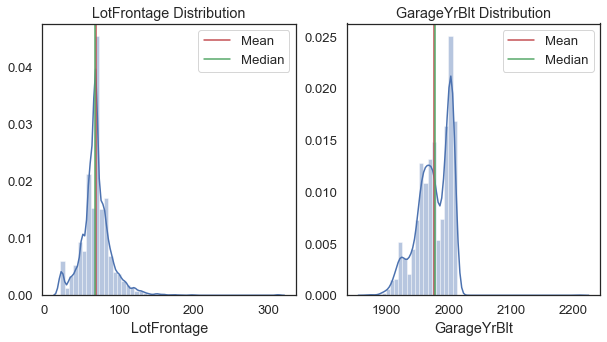

In [227]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(all_data["LotFrontage"].dropna(), ax=ax[0])
ax[0].axvline(x=all_data["LotFrontage"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[0].axvline(x=all_data["LotFrontage"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[0].legend()
ax[0].set_title("LotFrontage Distribution")


sns.distplot(all_data["GarageYrBlt"].dropna(), ax=ax[1])
ax[1].axvline(x=all_data["GarageYrBlt"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[1].axvline(x=all_data["GarageYrBlt"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[1].legend()
ax[1].set_title("GarageYrBlt Distribution")

plt.show()

**Convert Select Numeric Features to Categorical Features**

In [228]:
# By making these substitutions, the columns are automatically cast to datatype object
for df in [X, test, all_data]:
    df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                               50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                               80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                               150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                               7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }, inplace=True)

**Remove/Fix Outliers**

First, let's address the `GrLivArea` outliers that are mentioned in the [author's original paper](http://jse.amstat.org/v19n3/decock.pdf) on pg. 4. Here, we remove the unusual homes that are more than 4000 square feet.

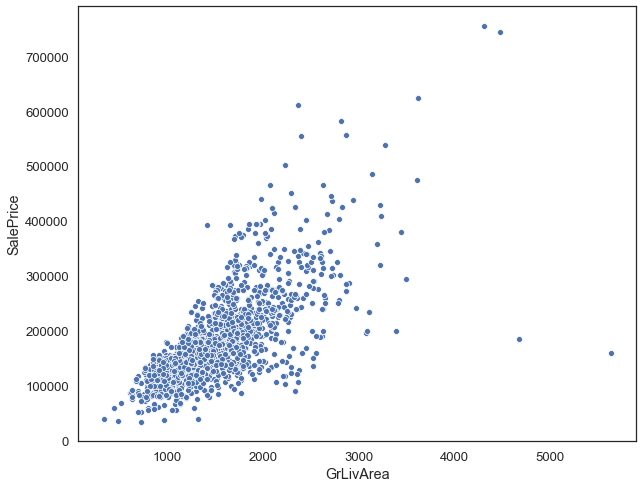

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,SC60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,None,None,None,0,Oct,2007,New,Partial,184750
691,SC60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,Jan,2007,WD,Normal,755000
1182,SC60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,None,0,Jul,2007,WD,Abnorml,745000
1298,SC60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,None,None,0,Jan,2008,New,Partial,160000


In [229]:
sns.scatterplot(x=X["GrLivArea"], y=X["SalePrice"])
plt.show()

X[X["GrLivArea"] > 4000]

In [230]:
# Remove GrLivArea outliers
X = X.drop([523, 691, 1182, 1298])

Next, let's fix the `GarageYrBlt` value for one particular house in the test set by assuming that 2207 is supposed to be 2007.

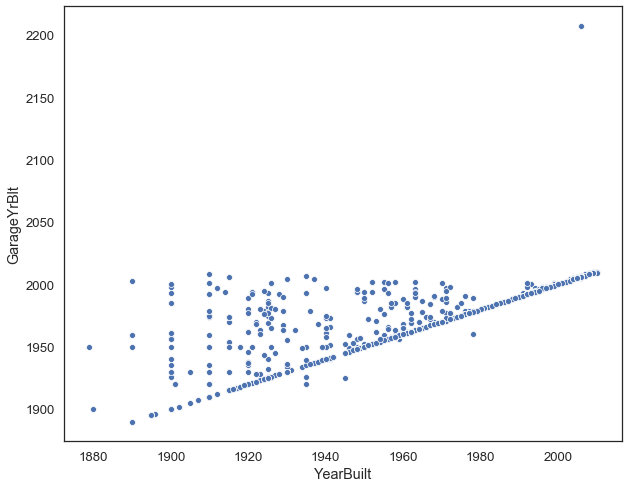

In [231]:
sns.scatterplot(x=test["YearBuilt"], y=test["GarageYrBlt"])
plt.show()

In [232]:
# Assume that 2207 was meant to be 2007
test.loc[test["GarageYrBlt"] == 2207] = 2007

**Pre-Processing**

In [233]:
numeric_features = np.array([c for c in X.select_dtypes(include=[np.number]).columns if c != "SalePrice"])
numeric_features

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'],
      dtype='<U13')

In [234]:
categorical_features = np.array(X.select_dtypes(include=[np.object]).columns)
categorical_features

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition'], dtype=object)

In [235]:
X[categorical_features].head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition
0,SC60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,Feb,WD,Normal
1,SC20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,May,WD,Normal
2,SC60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,Sep,WD,Normal
3,SC70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,Feb,WD,Abnorml
4,SC60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,Dec,WD,Normal


**Log-Transform Skewed Numeric Variables**

In [236]:
X["SalePrice"] = np.log1p(X["SalePrice"]) # SalePrice
skew_threshold = 0.5 # As a general rule of thumb, |skew| > 0.5 is considered moderately skewed

for df in [X[numeric_features], test[numeric_features]]:
    skewness = df.apply(lambda x: stats.skew(x))
    skewness = skewness[np.abs(skewness) > skew_threshold]
    skewed_cols = skewness.index
    log_transformed_cols = np.log1p(df[skewed_cols])
    df[skewed_cols] = log_transformed_cols
    print("Transforming {} features...".format(len(skewed_cols)))

Transforming 26 features...
Transforming 31 features...


D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Baseline Model using Numeric Data Only**

In [237]:
def compare_ridge_lasso(X, y):
    plt.figure(figsize=(5,5))
    alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
    cv_ridge = [rmse_cv(Ridge(alpha=alpha), X, y).mean() for alpha in alphas]
    cv_ridge = pd.Series(cv_ridge, index=alphas)
    best_alpha_ridge = alphas[np.argmin(cv_ridge.values)]
    sns.lineplot(x=alphas, y=cv_ridge)
    plt.title("Ridge Regression - Alpha Optimization")
    plt.xlabel("Alpha")
    plt.ylabel("RMSE")

    print("Best RMSE for Ridge Regression = {:.4f} for alpha = {}".format(cv_ridge.min(), best_alpha_ridge))
    plt.show()

    plt.figure(figsize=(5,5))
    alphas = np.linspace(2**(-7), 2**3, num=10)
    cv_lasso = [rmse_cv(Lasso(alpha=alpha), X, y).mean() for alpha in alphas]
    cv_lasso = pd.Series(cv_lasso, index=alphas)
    best_alpha_lasso = alphas[np.argmin(cv_lasso.values)]
    sns.lineplot(x=alphas, y=cv_lasso)
    plt.title("Lasso Regression - Alpha Optimization")
    plt.xlabel("Alpha")
    plt.ylabel("RMSE")

    print("Best RMSE for Lasso Regression = {:.4f} for alpha = {}".format(cv_lasso.min(), best_alpha_lasso))
    plt.show()
    
    return Ridge(alpha=best_alpha_ridge) if cv_ridge.min() < cv_lasso.min() else Lasso(alpha=best_alpha_lasso)

Best RMSE for Ridge Regression = 0.1294 for alpha = 5


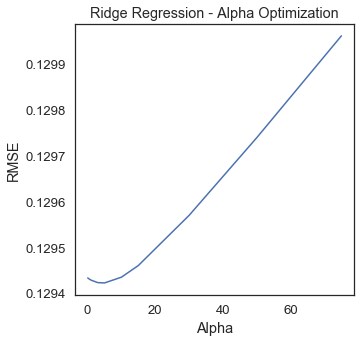

Best RMSE for Lasso Regression = 0.1321 for alpha = 0.0078125


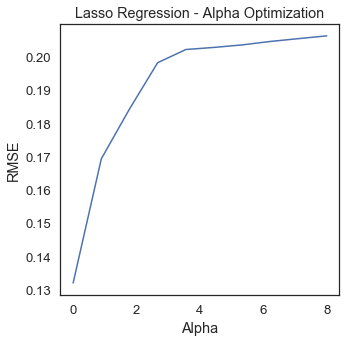

In [238]:
numeric_model = compare_ridge_lasso(X[numeric_features], X["SalePrice"])

**Baseline Predictions Using Numeric Data Only**

In [239]:
numeric_model.fit(X[numeric_features], X["SalePrice"])
predictions = np.expm1(numeric_model.predict(test[numeric_features]))
submission["SalePrice"] = predictions
predictions

array([122169.99104251, 142315.72875631, 175148.14847993, ...,
       192621.84426892, 117129.54590972, 239837.24820269])

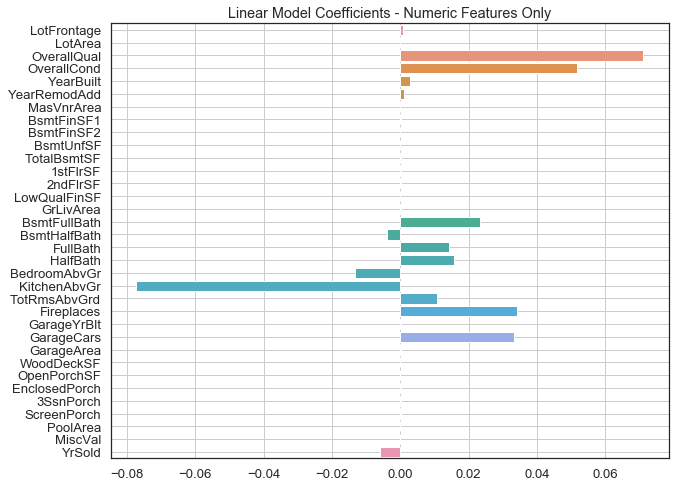

In [240]:
fig, ax = plt.subplots()
sns.set_style("darkgrid")

coefs = numeric_model.coef_
sns.barplot(x=coefs, y=X[numeric_features].columns, orient='h', ax=ax)
ax.grid()
plt.title("Linear Model Coefficients - Numeric Features Only")
plt.show()

**LabelEncode the Ordinal Features**

Using the data description file, we can determine which categorical columns refer to ordinal characteristics and replace feature values with ordered numbers.

In [241]:
ordinal_features = ["ExterQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
                "LandSlope", "ExterCond", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", 
                "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "LotShape", "Utilities"]
nominal_features = list(set(categorical_features) - set(ordinal_features))

In [242]:
for df in [X, test, all_data]:
    df.replace({"BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "BsmtExposure" : {"None" : 0, "No": 0, "Mn" : 1, "Av": 2, "Gd" : 3},
               "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
               "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
               "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
               "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
               "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
               "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
               "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
               "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
               "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
               "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
               "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                , inplace=True)

**One-Hot Encode the Nominal Features**

In [243]:
# https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
X_nominal = pd.get_dummies(X[nominal_features])
test_nominal = pd.get_dummies(test[nominal_features])
X_nominal, test_nominal = X_nominal.align(test_nominal, join="left", axis=1)

In [244]:
set(X_nominal.columns) - set(test_nominal.columns)

set()

In [245]:
y = X.pop("SalePrice")
X = pd.concat([X[numeric_features], X[ordinal_features], X_dummies], axis=1)
test = pd.concat([test[numeric_features], test[ordinal_features], test_dummies], axis=1)

In [246]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,LandSlope,ExterCond,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,LotShape,Utilities,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Alley_Grvl,Alley_None,Alley_Pave,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSSubClass_SC120,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,MSSubClass_SC85,MSSubClass_SC90,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,MoSold_Apr,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Street_Grvl,Street_Pave,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,PavedDrive_N,PavedDrive_P,PavedDrive_Y,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,CentralAir_N,CentralAir_Y,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
0,65.0,8450,7,5,2003,2003,196.0,706,0,

**Split Data for Modeling**

In [247]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [248]:
standard_scaler = StandardScaler()
X_train.loc[:,numeric_features] = standard_scaler.fit_transform(X_train[numeric_features])
X_valid.loc[:,numeric_features] = standard_scaler.transform(X_valid[numeric_features])

D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Best RMSE for Ridge Regression = 0.1144 for alpha = 30


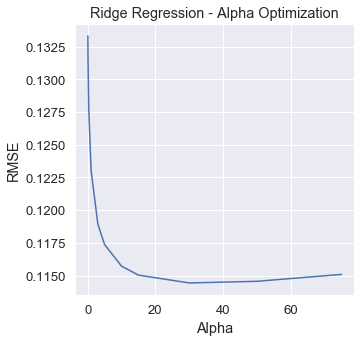

Best RMSE for Lasso Regression = 0.1263 for alpha = 0.0078125


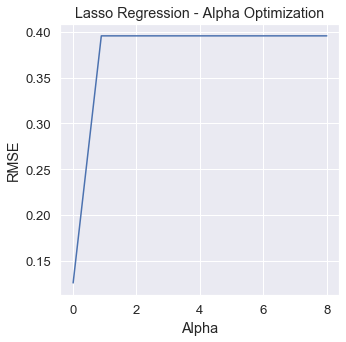

In [251]:
model = compare_ridge_lasso(X_train, y_train)

In [250]:
# model = compare_ridge_lasso(X, y)
# model.fit(X, y)
# preds = np.expm1(model.predict(test))
# preds[0:5]